In [1]:
from pyimzml.ImzMLParser import ImzMLParser, getionimage
import numpy as np
#import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import os
matplotlib.rcParams['figure.dpi'] = 100
import helper
import molmass
from PIL import Image
from multiprocessing import Pool
import importlib
importlib.reload(helper)
import zipfile
from sklearn.metrics import r2_score
import matplotlib.animation as animation
from IPython.display import HTML
matplotlib.rcParams['animation.writer'] = 'ffmpeg'


def extractIntensity(mz,spectrum,ppm,mode="profile"):
    if mode == "centroid":
        width = ppm * mz / 1e6
    else:
        width = mz / ppm / 2
    mz_start = mz - width
    mz_end = mz + width
    intensity = np.sum([i for mz,i in spectrum.items() if mz > mz_start and mz < mz_end])
    return intensity

def mergeMzLists(old,new,ppm,mode):
    for x in new:
        unique = True
        if mode == "centroid":
            width = ppm * x / 1e6
        else:
            width = mz / x / 2
        mi = x - width
        ma = x + width
        for y in old:
            if y > mi and y < ma:
                unique = False
                break
        if unique:
            old.append(x)
    return old

def reformat_data(tensor,mzs,string=""):
    nrows = tensor.shape[1]
    ncols = tensor.shape[2]
    ntotal = nrows * ncols
    df = pd.DataFrame(index=range(ntotal))

    for met,i in zip(mzs,range(len(tensor))):
        x = []
        y = []
        ints = []
        for r in range(nrows):
            for c in range(ncols):
                x.append(c)
                y.append(r)
                ints.append(tensor[i][r][c])
        df[met] = ints
                
    df["x"] = x
    df["y"] = y
    df = df[["x","y"] + list(df.columns.values[:-2])]
    return df

def writeFormattedData(data,fn,string):
    data.to_csv(fn,sep="\t")
    f = open(fn,"r")
    lines = f.readlines()
    f.close()
    f = open(fn,"w")
    f.write(string+"\n\n\n")
    [f.write(x) for x in lines]
    f.close()
    
    

def animate(images):
    fig,ax = plt.subplots()
    i = 0
    ims = []
    for im in images:
        if i == 0:
            ax.imshow(im)
        im = ax.imshow(im,animated=True)
        ims.append([im])
        i += 1
    ani = animation.ArtistAnimation(fig,ims,interval=50,blit=True,repeat_delay=1000)
    return ani


In [2]:
filename = "maldi/data/20211103singlecell.imzML" #path to imzML
ppm = 20
intensityCutoff = 1000

In [3]:
p = ImzMLParser(filename) #load data

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\pyimzml\ontology\ontology.py:94: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  % (accession, raw_name, name)


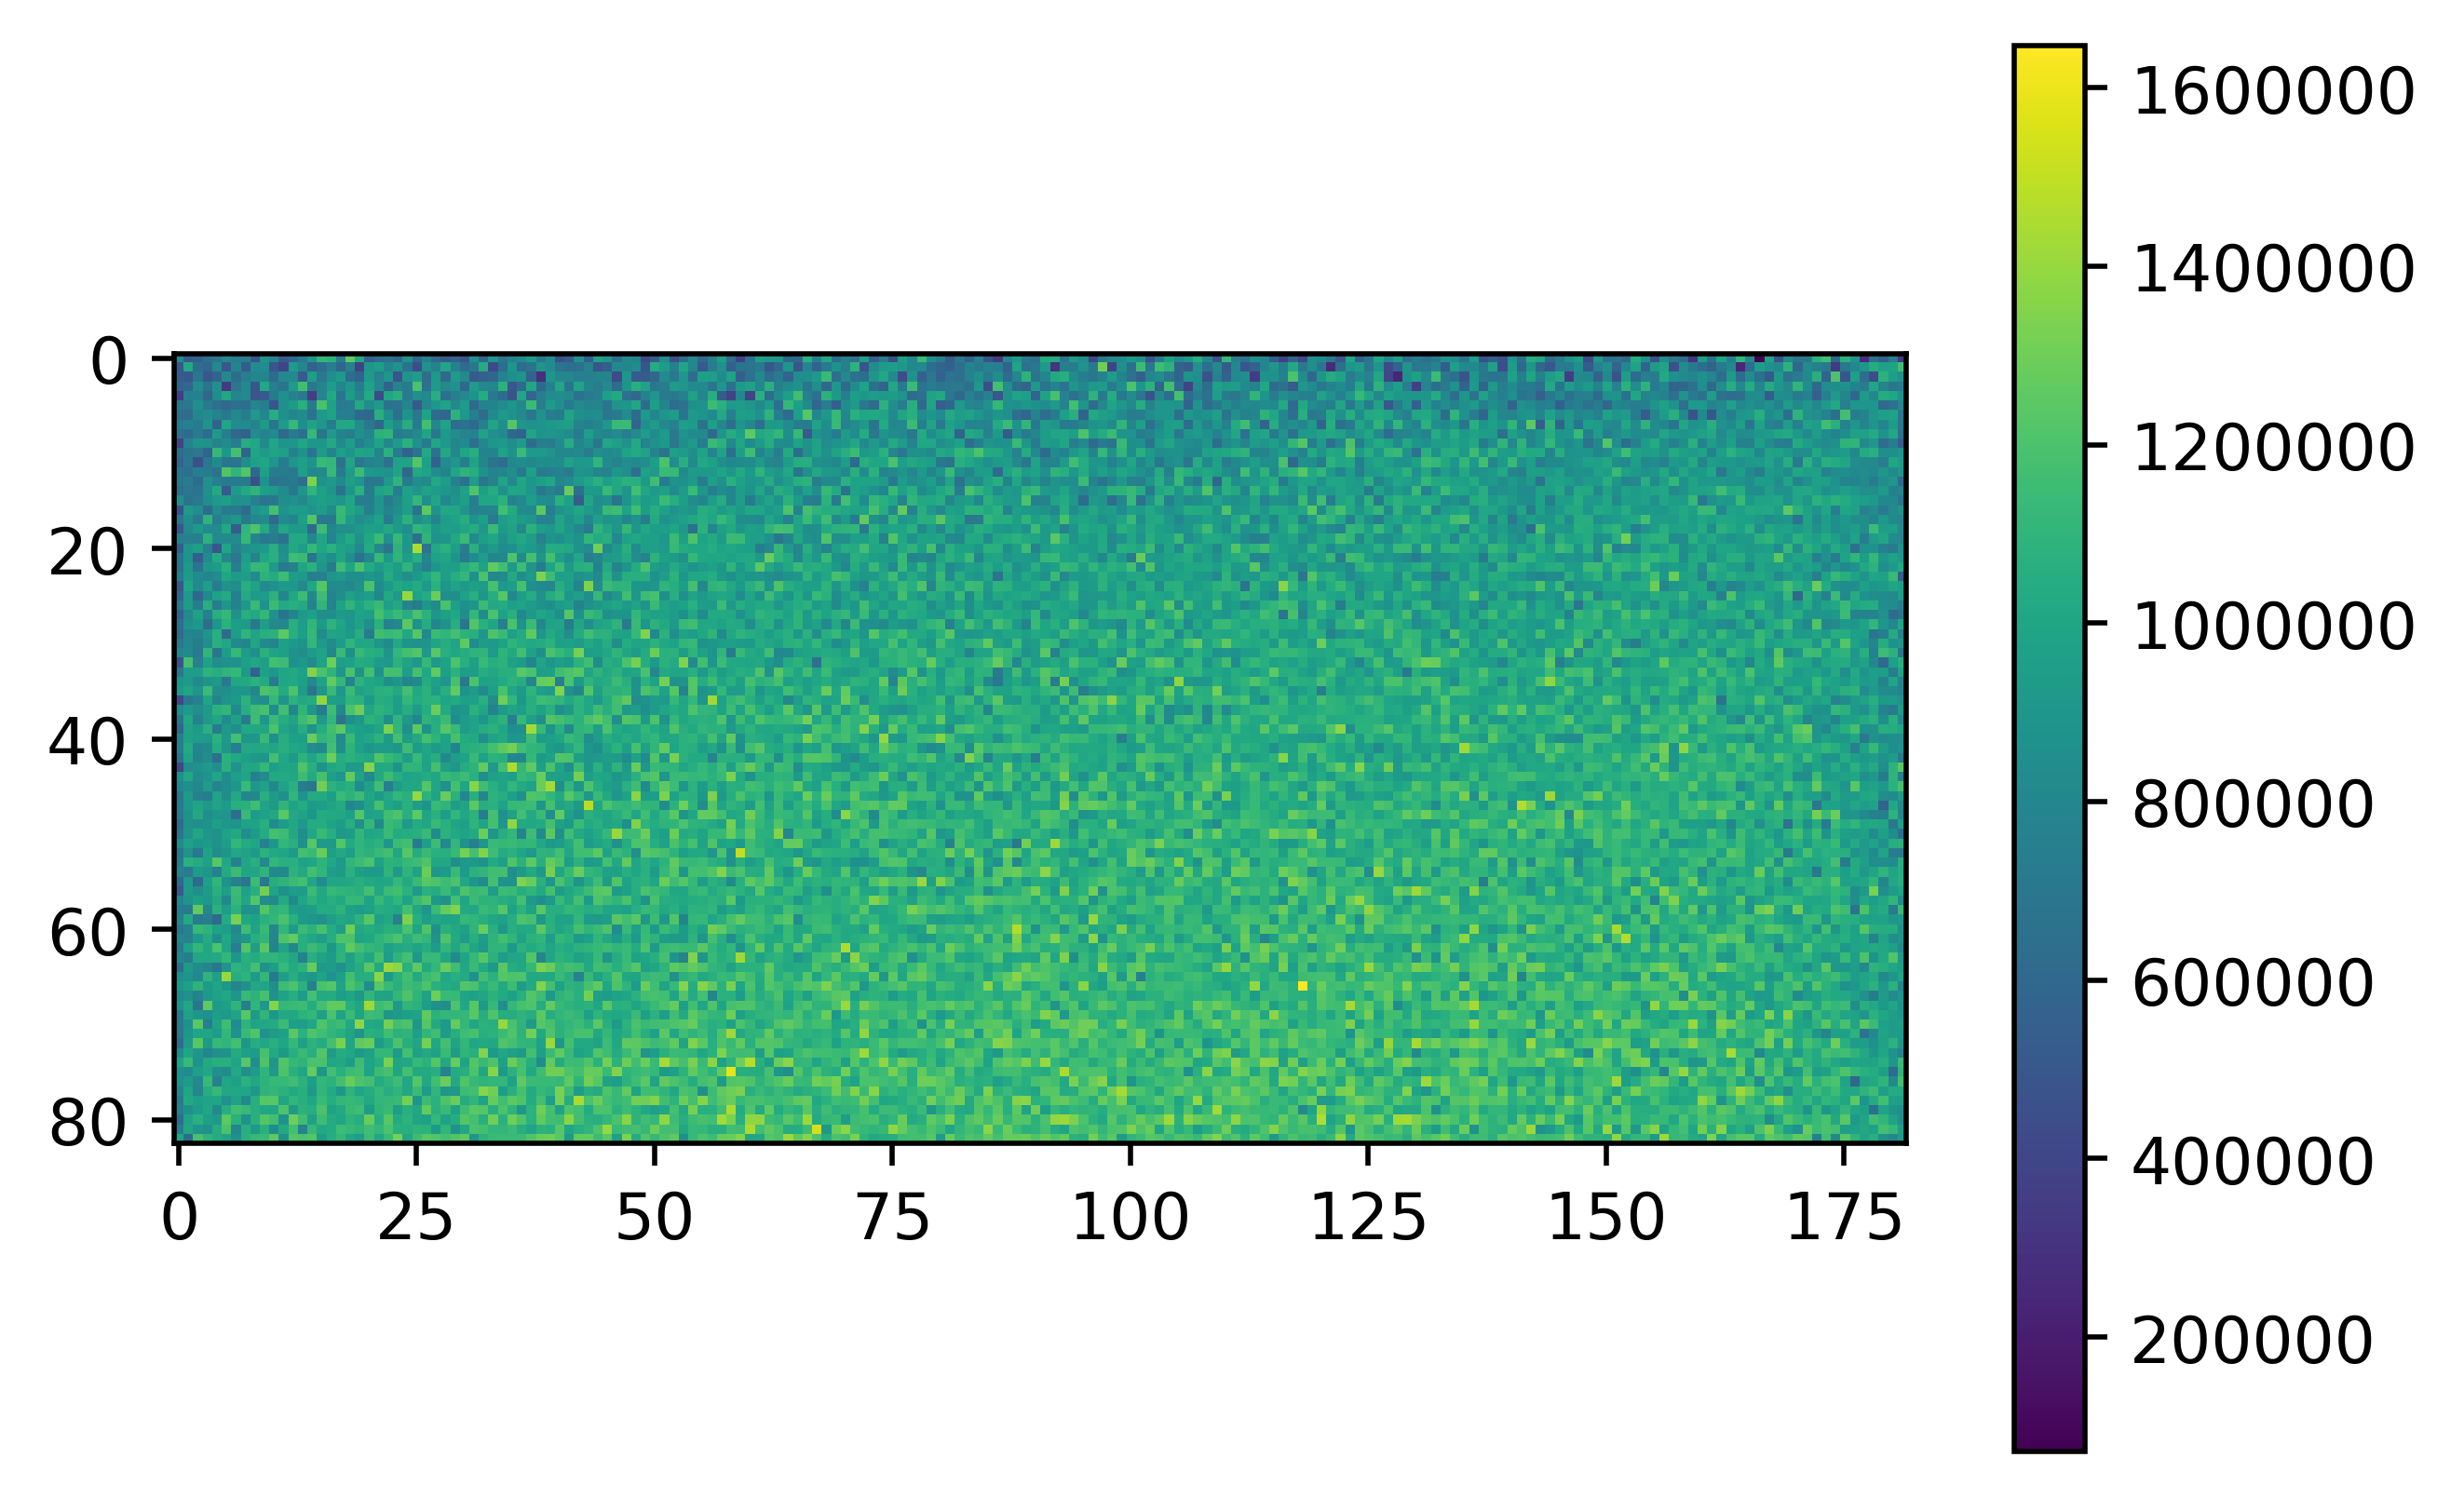

In [4]:
tic_image = getionimage(p,500,500) #make and plot TIC image
plt.imshow(tic_image)
plt.colorbar()

In [5]:
#gather mzs of interest
mzList = []
for idx, (x,y,z) in enumerate(p.coordinates):
    mzs, intensities = p.getspectrum(idx)
    mzs = [mzs[x] for x in range(len(mzs)) if intensities[x] > intensityCutoff]
    mzList = mergeMzLists(mzList,mzs,ppm,"centroid")
mzList.sort()
print(len(mzList), "m/z values detected")

653 m/z values detected


In [6]:
ppm = 20
ion_images = np.zeros((len(mzList),tic_image.shape[0],tic_image.shape[1]))
for idx, (x,y,z) in enumerate(p.coordinates):
    mzs, intensities = p.getspectrum(idx)
    spectrum = {mz:i for mz,i in zip(mzs,intensities)}
    for i in range(len(mzList)):
        ion_images[i,y-1,x-1] = extractIntensity(mzList[i],spectrum,ppm,"centroid")
    

In [7]:
#print(ion_images.shape)
#ani = animate(ion_images[:50])
#HTML(ani.to_html5_video())

In [8]:
df = reformat_data(ion_images,mzList)

In [9]:
writeFormattedData(df,filename.replace(".imzML",".txt"),string=filename+", ppm="+str(ppm)+", intensity threshold="+str(intensityCutoff))

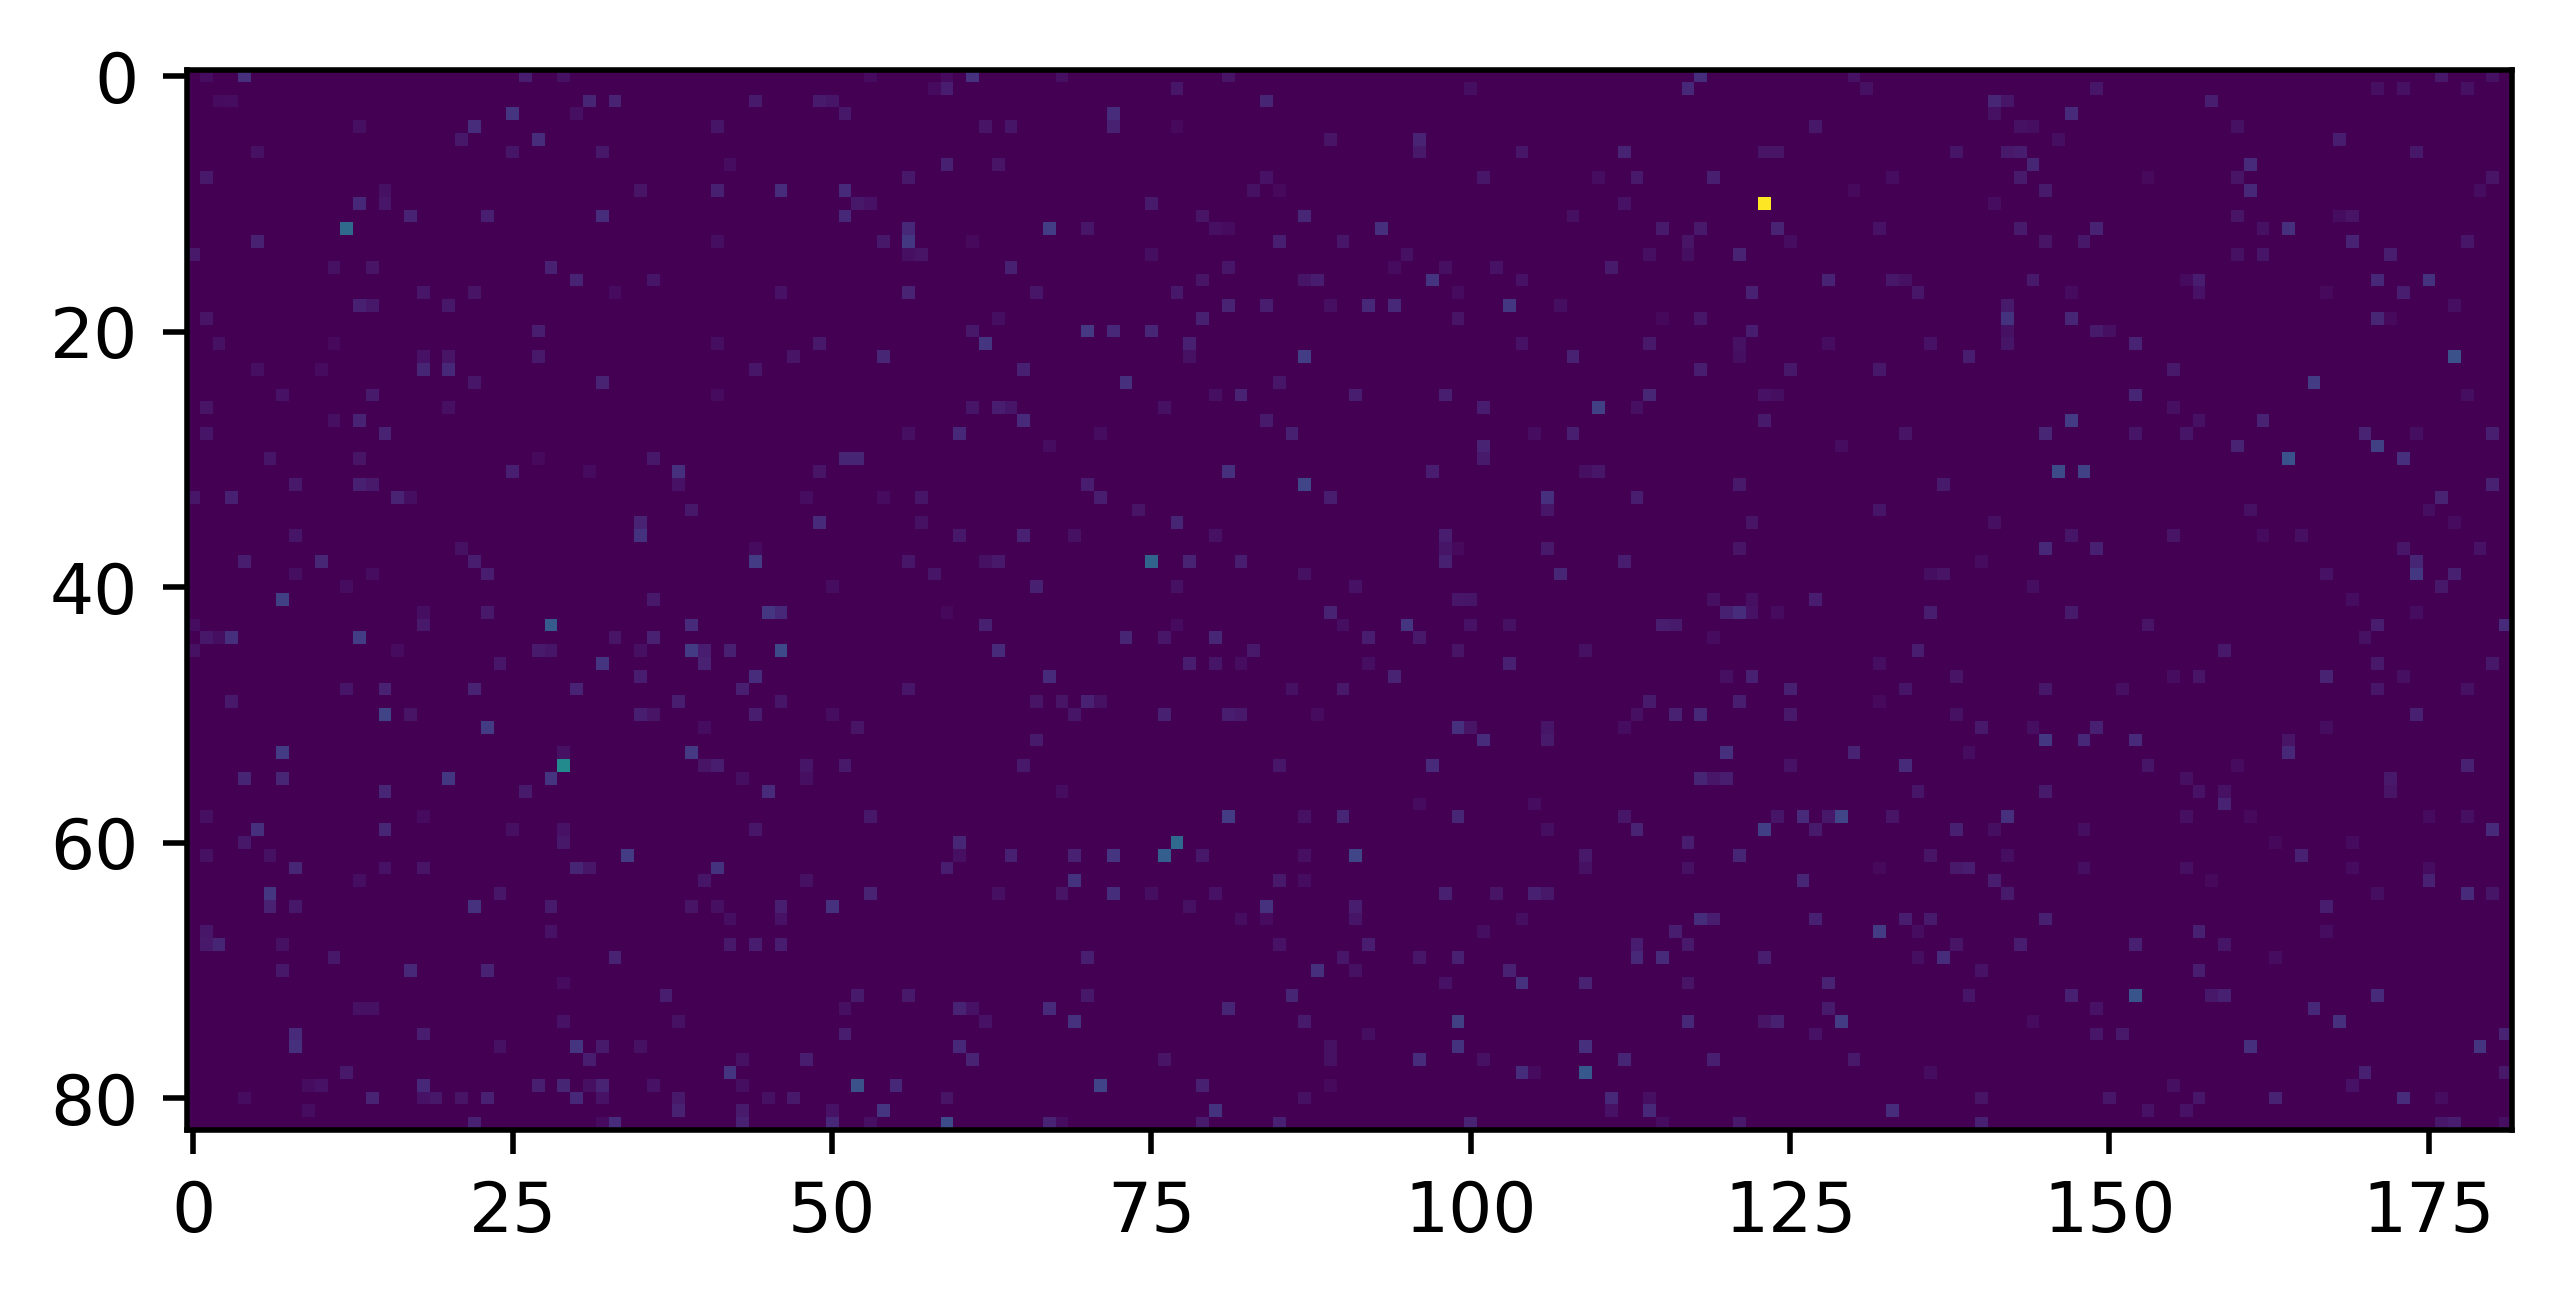